# AACR slides: Entropy and correlation analysis

### Mount data directory

In [1]:
!gcsfuse --implicit-dirs scrnaseq_benchmarking ~/data/

2022/03/19 23:20:59.448798 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /home/jtsuji/data
2022/03/19 23:20:59.469652 Opening GCS connection...
2022/03/19 23:20:59.709186 Mounting file system "scrnaseq_benchmarking"...
2022/03/19 23:20:59.731376 File system has been successfully mounted.


### Load libraries

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc

### Load AnnData

In [5]:
# (69.12 GiB) gs://scrnaseq_benchmarking/aacr/mal_cells_for_junko_adata.h5ad
adata = sc.read_h5ad("/home/jtsuji/data/aacr/mal_cells_for_junko_adata.h5ad")

adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,scrublet_score,doublet,sample_id,bcr_raw_clonotype_id,bcr_clono_co,batch,plas_call
barcode,,,,,,,,,,,,,,,,
GACAGAGAGTGACTCT-1-0-0,2.680493,0.999986,6747.285156,TPC,3443,32340.0,214.0,0.661719,3443,0.058954,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
CATCGAATCATTGCGA-1-0-0,2.592071,0.999983,6423.836426,TPC,3061,31452.0,162.0,0.515071,3061,0.040225,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
AGCAGCCAGGACAGAA-1-0-0,2.554361,0.999979,6736.926758,TPC,3295,29711.0,223.0,0.750564,3295,0.130590,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
GCGACCATCCGAAGAG-1-0-0,2.505002,0.999977,7024.260742,TPC,3232,29400.0,267.0,0.908163,3232,0.117207,False,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
TTCTCAATCTAGCACA-1-0-0,2.694450,0.999979,7314.036133,TPC,3737,29220.0,355.0,1.214921,3737,0.219448,True,pM10109_1_BM_CD138pos_GEX_5,clonotype1,c1,0,tum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTATTCTCAAGCCTA-1-8-10,0.559692,0.999015,7608.150879,LQTPC,569,827.0,58.0,7.013301,569,0.051087,True,pM1831_2_PB_CD138pos_GEX_5,NaN,NA,10,tum
AGATTGCGTAAGTAGT-1-8-10,0.653077,0.999217,7586.197754,LQTPC,452,736.0,135.0,18.342390,452,0.007548,False,pM1831_2_PB_CD138pos_GEX_5,NaN,NA,10,tum
GACTAACCACGCTTTC-1-8-10,0.757090,0.998454,7705.398926,LQTPC,566,770.0,45.0,5.844156,566,0.145455,True,pM1831_2_PB_CD138pos_GEX_5,NaN,NA,10,tum


### Combine metadata with AnnData

In [6]:
import copy

# load metadata
meta = pd.read_csv("/home/jtsuji/mm-single-cell-analysis-2022/notebooks/violin_metadata.csv", dtype=str)
meta['patient_id'] = meta["PAIR_NUMBER"]+"_"+meta["DISEASE_STAGE"]

# define new column names to link with AnnData ('patient_id' is new)
#          old column               new column
cols  = { "patient_id"           : "patient_id",
          "REDCAP_ID"            : "redcap_id",
          "tissue_type"          : "tissue_type",
          "IMMUNOFIX_LIGHT_CHAIN": "ifx",
          "DISEASE_STAGE"        : "disease",
          "20_2_20_RISK_STATUS"  : "risk",
          "CG"                   : "group" }

# create sample ID based dictionary from metadata
meta_dict = dict()
for i, row in meta.iterrows():
    row_i = dict(row[[c for c in cols.keys() if c != "tissue_type"]])
    for bm_id in row["BM_CATISSUE_SAMPLE_ID"].split("/"):
        sid = bm_id + "_BM"
        meta_dict.setdefault(sid, copy.deepcopy(row_i))
        meta_dict[sid]["tissue_type"] = "BM"
    for ctc_id in row["CTC_CATISSUE_SAMPLE_ID"].split("/"):
        sid = ctc_id + "_CTC"
        meta_dict.setdefault(sid, copy.deepcopy(row_i))
        meta_dict[sid]["tissue_type"] = "CTC"

# initialize new columns with NaN
for meta_col, new_col in cols.items():
    adata.obs[new_col] = pd.Series(np.full(adata.n_obs, np.nan), dtype=str)

# iterate and insert data
# this adata object is index by cell barcode (e.g. 'GACAGAGAGTGACTCT-1-0-0')
for cb, row in adata.obs.iterrows():
    s = adata.obs.loc[cb, "sample_id"].split("_")
    sid, sty = s[0], s[2]
    if sty == "BM":
        sid += "_BM"
    elif sty == "PB":
        sid += "_CTC"
    else:
        raise Exception("unknown type: {}".format(sty))
    for meta_col in map(str, meta_dict[sid].keys()):
        adata.obs.at[cb, cols[meta_col]] = meta_dict[sid][meta_col]
 
adata.obs

,latent_RT_efficiency,latent_cell_probability,latent_scale,cell_type,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,scrublet_score,...,bcr_clono_co,batch,plas_call,patient_id,redcap_id,tissue_type,ifx,disease,risk,group
barcode,,,,,,,,,,,,,,,,,,,,,
GACAGAGAGTGACTCT-1-0-0,2.680493,0.999986,6747.285156,TPC,3443,32340.0,214.0,0.661719,3443,0.058954,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
CATCGAATCATTGCGA-1-0-0,2.592071,0.999983,6423.836426,TPC,3061,31452.0,162.0,0.515071,3061,0.040225,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
AGCAGCCAGGACAGAA-1-0-0,2.554361,0.999979,6736.926758,TPC,3295,29711.0,223.0,0.750564,3295,0.130590,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
GCGACCATCCGAAGAG-1-0-0,2.505002,0.999977,7024.260742,TPC,3232,29400.0,267.0,0.908163,3232,0.117207,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
TTCTCAATCTAGCACA-1-0-0,2.694450,0.999979,7314.036133,TPC,3737,29220.0,355.0,1.214921,3737,0.219448,...,c1,0,tum,3_SMM,PANGEA_3522,BM,IgG_Kappa,SMM,HRSMM,HRD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTATTCTCAAGCCTA-1-8-10,0.559692,0.999015,7608.150879,LQTPC,569,827.0,58.0,7.013301,569,0.051087,...,NA,10,tum,44_NDMM,PANGEA_4610,CTC,IgA_Lambda.Light_Chain_Only_Lambda,NDMM,NA_NDMM,t(14;16)
AGATTGCGTAAGTAGT-1-8-10,0.653077,0.999217,7586.197754,LQTPC,452,736.0,135.0,18.342390,452,0.007548,...,NA,10,tum,44_NDMM,PANGEA_4610,CTC,IgA_Lambda.Light_Chain_Only_Lambda,NDMM,NA_NDMM,t(14;16)
GACTAACCACGCTTTC-1-8-10,0.757090,0.998454,7705.398926,LQTPC,566,770.0,45.0,5.844156,566,0.145455,...,NA,10,tum,44_NDMM,PANGEA_4610,CTC,IgA_Lambda.Light_Chain_Only_Lambda,NDMM,NA_NDMM,t(14;16)


### Compute cell cycle scores
In this analysis, 97 genes from [Tirosh *et al*](https://www.science.org/doi/10.1126/science.aad0501) are used.  Since `scanpy` requires two sets of gene lists for G1/S and G2/M phases, the gene names on the Table S5 were directly used for the function.

In [12]:
# load G1/S and G2/M phase gene lists
g1s_phase_genes = [x.rstrip() for x in open("/home/jtsuji/mm-single-cell-analysis-2022/data/g1s_phase_genes.txt")]
g2m_phase_genes = [x.rstrip() for x in open("/home/jtsuji/mm-single-cell-analysis-2022/data/g2m_phase_genes.txt")]

# run cell cycle gene scoring function
sc.tl.score_genes_cell_cycle(adata, s_genes=g1s_phase_genes, g2m_genes=g2m_phase_genes)

/usr/local/lib/python3.8/dist-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/usr/local/lib/python3.8/dist-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


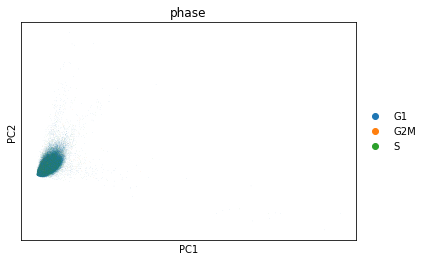

In [23]:
# plot cell cycle genes
cell_cycle_genes = [x for x in g1s_phase_genes+g2m_phase_genes if x in adata.var_names]
sc.pl.pca_scatter(adata[:, cell_cycle_genes], color='phase')

In [65]:
# function to compute cell cycle stats
def cell_cycle_stats(d, sid, tty):
    df = d.obs[(d.obs.patient_id == sid) & (d.obs.tissue_type == tty)][["S_score", "G2M_score", "phase"]]
    phase_stats = df.phase.value_counts()
    return (len(df.index),         # total number of cells
            phase_stats["G1"],     # number of cells in G1 phase
            phase_stats["S"],      # number of cells in S phase
            phase_stats["G2M"],    # number of cells in G2M phase
            df.S_score.mean(),     # mean S score
            df.S_score.median(),   # median S score
            df.G2M_score.mean(),   # mean G2M score
            df.G2M_score.median()) # median G2M score

header = ["patient_id", "tissue_type", "total_cell", "g1_phase_cell", "s_phase_cell", "g2m_phase_cell",
          "s_score_mean", "s_score_median", "g2m_score_mean", "g2m_score_median"]
fo = open("/home/jtsuji/mm-single-cell-analysis-2022/tables/tumor_cell_cycle_annotation_scores.txt", "w")
fo.write("\t".join(header)+"\n")
for sid in meta.patient_id:
    fo.write("\t".join([sid, "BM"] + list(map(str, cell_cycle_stats(adata, sid, "BM")))) + "\n")
    fo.write("\t".join([sid, "CTC"] + list(map(str, cell_cycle_stats(adata, sid, "CTC")))) + "\n")
fo.close()

pd.read_csv("/home/jtsuji/mm-single-cell-analysis-2022/tables/tumor_cell_cycle_annotation_scores.txt", sep="\t")

,patient_id,tissue_type,total_cell,g1_phase_cell,s_phase_cell,g2m_phase_cell,s_score_mean,s_score_median,g2m_score_mean,g2m_score_median
0,1_SMM,BM,547,446,94,7,-0.033163,-0.034133,-0.101773,-0.104212
1,1_SMM,CTC,105,90,15,0,-0.035289,-0.038960,-0.117512,-0.116233
2,2_SMM,BM,10051,7490,2196,365,-0.015435,-0.023295,-0.065803,-0.073953
3,2_SMM,CTC,79,78,1,0,-0.047115,-0.046358,-0.098962,-0.100772
4,3_SMM,BM,16064,12862,2706,496,-0.021906,-0.028379,-0.067856,-0.076213
...,...,...,...,...,...,...,...,...,...,...
85,42_MGUS,CTC,107,94,12,1,-0.022889,-0.020000,-0.071155,-0.073493
86,43_MGUS,BM,3255,2698,541,16,-0.026495,-0.030089,-0.085587,-0.088289
87,43_MGUS,CTC,21,17,4,0,-0.032116,-0.036954,-0.097260,-0.096687
88,44_NDMM,BM,15197,9489,5561,147,-0.003027,-0.011623,-0.082858,-0.088103


### Neighboring cell entropy analysis

Every CTC, we need to extract its 30 nearest neighbors. Then, we have to compute four types of entropy: matched marrow (MM), matched blood (MB), unmatched marrow (UM), unmatched blood (UB). Calculate entropy like so: `-sum(p*log(p))/log(N)`.

p is the proportion of neighbors that have the correct label for the given type of entropy; N is the total number of possible labels. For example, in the case of MM entropy, p would be the proportion of 30 neighbors that have the sample label of the marrow that matches the given CTC whose entropy we are calculating. Once we have computed all entropies for all cells, we can visualize results with a set of boxplots, whereby the x axis corresponds to each individual CTC sample (which can be thought of as a patient, too), and each sample/patient is "split" into 4 boxplots (MM, MB, UM, UB) visualizing the distribution of entropies for all CTCs in the sample/patient. The hope is that in all cases, MB will have the lowest entropy, MM will have low entropy, UB will have higher entropy and UM will have the highest entropy. We can then perform Wilcoxon tests, to compare MM entropy to that of UM/UB and show that CTCs are transcriptionally more similar to tumor cells from matched marrow.

In [5]:
# compute neighbors with the local neighborhood of 30
# (n=31 for the function to disregard self-node)
sc.pp.neighbors(adata,
                n_neighbors=31,
                n_pcs=40,
                knn=True,
                method="umap")

AnnData object with n_obs × n_vars = 420816 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'scrublet_score', 'doublet', 'sample_id', 'bcr_raw_clonotype_id', 'bcr_clono_co', 'batch', 'plas_call', 'patient_id', 'redcap_id', 'tissue_type', 'ifx', 'disease', 'risk', 'group'
    var: 'id', 'feature_type', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca', 'latent_gene_encoding'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient_id' as categorical
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'redcap_id' as categorical
/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new C

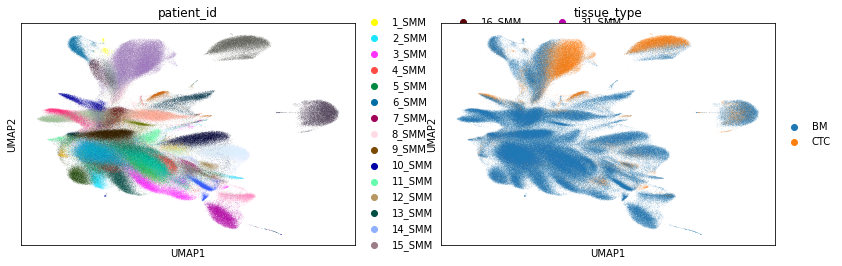

In [10]:
# compute UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=["patient_id", "tissue_type"])

In [35]:
# handle distance matrix (pairwise sparse matrix)
total_cells = adata.shape[0]
barcode = list(adata.obs.index)

for i in total_cells:
    x = adata.obs.loc[barcode[i], ["patient_id", "tissue_type"]]
    cell_patient_id = x["patient_id"]
    cell_tissue_type = x["tissue_type"]
    for j in adata.obsp["distances"].getrow(i).indices:
        y = adata.obs.loc[barcode[j], ["patient_id", "tissue_type"]]
        neighbor_patient_id = y["patient_id"]
        neighbor_tissue_type = y["tissue_type"]
        # do comparison

3_SMM


### Cell vs cell gene expression analysis

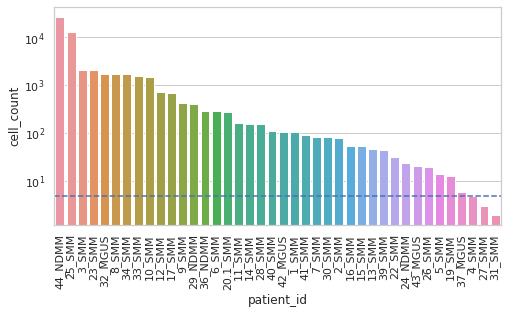

total patients = 40
44_NDMM     26709
25_SMM      13291
3_SMM        2128
23_SMM       2109
32_MGUS      1727
8_SMM        1710
34_SMM       1697
33_SMM       1591
10_SMM       1495
12_SMM        710
17_SMM        677
9_SMM         435
29_NDMM       412
36_NDMM       290
6_SMM         288
20.1_SMM      283
11_SMM        164
14_SMM        158
28_SMM        154
40_SMM        110
42_MGUS       107
1_SMM         105
41_SMM         93
7_SMM          84
30_SMM         83
2_SMM          79
16_SMM         54
15_SMM         54
13_SMM         46
39_SMM         44
22_SMM         32
24_NDMM        24
43_MGUS        21
26_SMM         20
5_SMM          14
19_SMM         13
37_MGUS         6
4_SMM           5
27_SMM          3
31_SMM          2
Name: patient_id, dtype: int64


In [7]:
import seaborn as sns
import matplotlib.pylab as plt

# check samples to filter first
# get CTC cell counts per sample
counts = adata[adata.obs.tissue_type == "CTC"].obs.patient_id.value_counts()
ctc_counts = pd.DataFrame({"patient_id":counts.keys(), "cell_count":[c for c in counts]})

# plot CTC cell counts
sns.set(rc = {'figure.figsize':(8,4)})
sns.set_style("whitegrid")
p = sns.barplot(data=ctc_counts, x="patient_id", y="cell_count")
p.set_yscale("log")
p.axhline(5, ls="--")
plt.xticks(rotation=90)
plt.show()

print("total patients = {}".format(len(counts.keys())))
print(counts)

In [11]:
# extract patients with sufficient CTC
sids = list(ctc_counts[ctc_counts["cell_count"] >= 5]["patient_id"])
adata = adata[adata.obs.patient_id.isin(sids)]

# output median gene expression in each cell type
fo = open("/home/jtsuji/mm-single-cell-analysis-2022/tables/cell_type_median_gene_expr.txt", "w")
fo.write("\t".join(["sample"] + list(adata.var_names)) + "\n")

# compute median/mean 
ctc = {"mean":dict(), "median":dict(), "std":dict()}
bm = {"mean":dict(), "median":dict(), "std":dict()}
for i,sid in enumerate(sids):
    print("computing {}.... ({}/{})".format(sid, i+1, len(sids)))
    # get CTC/BM cell barcode index
    ctc_index = (adata.obs.patient_id == sid) & (adata.obs.tissue_type == "CTC")
    bm_index = (adata.obs.patient_id == sid) & (adata.obs.tissue_type == "BM")
    # compute median, mean, standard deviation across cells
    ctc["median"][sid] = np.median(adata[ctc_index].X, axis=0)
    ctc["mean"][sid] = np.mean(adata[ctc_index].X, axis=0)
    ctc["std"][sid] = np.std(adata[ctc_index].X, axis=0)
    bm["median"][sid] = np.median(adata[bm_index].X, axis=0)
    bm["mean"][sid] = np.mean(adata[bm_index].X, axis=0)
    bm["std"][sid] = np.std(adata[bm_index].X, axis=0)
    # write median gene expression in a file
    fo.write("\t".join([sid+"_CTC"] + list(map(str, ctc["median"][sid]))) + "\n")
    fo.write("\t".join([sid+"_BM"] + list(map(str, bm["median"][sid]))) + "\n")

fo.close()
print("...done!")

computing 44_NDMM.... (1/38)
computing 25_SMM.... (2/38)
computing 3_SMM.... (3/38)
computing 23_SMM.... (4/38)
computing 32_MGUS.... (5/38)
computing 8_SMM.... (6/38)
computing 34_SMM.... (7/38)
computing 33_SMM.... (8/38)
computing 10_SMM.... (9/38)
computing 12_SMM.... (10/38)
computing 17_SMM.... (11/38)
computing 9_SMM.... (12/38)
computing 29_NDMM.... (13/38)
computing 36_NDMM.... (14/38)
computing 6_SMM.... (15/38)
computing 20.1_SMM.... (16/38)
computing 11_SMM.... (17/38)
computing 14_SMM.... (18/38)
computing 28_SMM.... (19/38)
computing 40_SMM.... (20/38)
computing 42_MGUS.... (21/38)
computing 1_SMM.... (22/38)
computing 41_SMM.... (23/38)
computing 7_SMM.... (24/38)
computing 30_SMM.... (25/38)
computing 2_SMM.... (26/38)
computing 16_SMM.... (27/38)
computing 15_SMM.... (28/38)
computing 13_SMM.... (29/38)
computing 39_SMM.... (30/38)
computing 22_SMM.... (31/38)
computing 24_NDMM.... (32/38)
computing 43_MGUS.... (33/38)
computing 26_SMM.... (34/38)
computing 5_SMM.... (

In [13]:
# compute correlation coefficient and p-values, and write out the correlation to a file
from scipy import stats

def correlation_file(fn, key, sids, ctc, bm):
    cor = []
    fo = open(fn, "w")
    fo.write("\t".join(["x"] + [sid+"_BM" for sid in sids]) + "\n")
    for x in sids:
        row = []
        for y in sids:
            r, pval = stats.pearsonr(ctc[key][x], bm[key][y])       
            row.append(r)
        fo.write("\t".join([x+"_CTC"] + list(map(str, row))) + "\n")
        cor.append(row)
    fo.close()
    return cor

cor_median = correlation_file("/home/jtsuji/mm-single-cell-analysis-2022/tables/cell_group_median_corr.txt",
                              "median", sids, ctc, bm)
cor_mean = correlation_file("/home/jtsuji/mm-single-cell-analysis-2022/tables/cell_group_mean_corr.txt",
                              "mean", sids, ctc, bm)

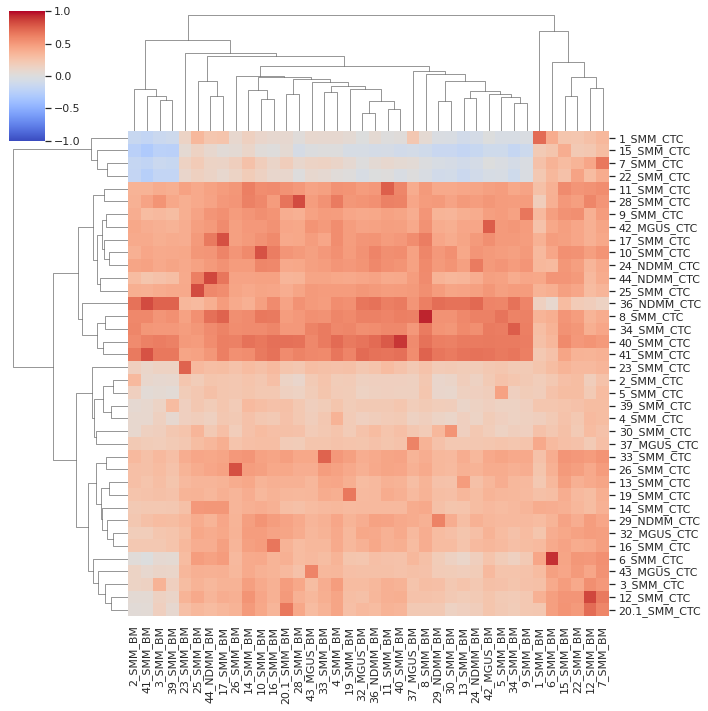

In [14]:
sns.set(rc = {'figure.figsize':(14,12)})
sns.clustermap(cor_median,
            xticklabels=[sid+"_BM" for sid in sids],
            yticklabels=[sid+"_CTC" for sid in sids],
            vmin=-1, vmax=1, center=0, cmap="coolwarm")

In [12]:
adata.X.shape

(374615, 36601)